In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(rtracklayer)
    library(scales)
    library(viridis)
    library(matrixStats)
});
options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml", digits=3);
theme_set(theme_classic(base_family = "Lucida Sans"));
mycols = c( 'gray', 'firebrick', 'forestgreen' );

In [2]:
# Download from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE60456&format=file
TSS = import("./data/tss_all_gm12878.bed.gz");

xcols = c(cl1 = "character", cl2="character");
dTSS = import( "./data/hg19.gm12878.pair.div.bed.gz", format='bed', extraCols=xcols );
start(dTSS) = start(dTSS);
end(dTSS) = end(dTSS);

In [3]:
# load GRO-cap signal; also from GSE60456
bwpl = import( "./data/groseq_gm12878_wTAP_plus.bw" , which=TSS[strand(TSS) == "+"] );
bwmn = import( "./data/groseq_gm12878_wTAP_minus.bw", which=TSS[strand(TSS) == "-"] );
strand(bwpl) = "+";
strand(bwmn) = "-";
bwmn$score = abs(bwmn$score);
bwTSS = append( bwpl, bwmn );
rm(bwpl, bwmn);

# sort so higher scores come first
bwTSS = bwTSS[order(bwTSS$score, decreasing=T)];
TSS$ID = 1:length(TSS);
hits = findOverlaps( bwTSS, TSS );
bwTSS$ID[hits@from] = TSS$ID[hits@to];
# remove duplicated IDs = remove weaker TSSs
bwTSS = bwTSS[!duplicated(bwTSS$ID)];
bwTSS = bwTSS[order(bwTSS$ID)];

TSS = promoters(bwTSS, upstream=200, downstream=30);

In [4]:
getLargestOverlap = function( query, subject ) {
    hits = findOverlaps(query, subject);
    overlaps = width(pintersect(query[hits@from], subject[hits@to]));
    
    # sort by overlap size (largest on top)
    hits = as.matrix(hits)[ order(overlaps, decreasing=T), ];
    # remove duplicates = smaller overlaps
    hits = hits[ !duplicated(hits[,1]), ];
    return(hits);
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20      38      48     120     104    2806 

Warning message:
“Removed 43889 rows containing non-finite values (stat_density).”


[1] 117613

[1] 106869

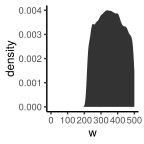

In [5]:
# load DHS peaks and chromHMM class
npcols = c(signalValue = "numeric", pValue = "numeric", qValue = "numeric", peak = "integer");
dhspk = import("./data/E116-DNase.macs2.narrowPeak.gz", format="bed", extraCols=npcols);
chromHMM = import("./data/E116_18_core_K27ac_mnemonics.bed.gz");

# focus on strong DHS peaks
summary(dhspk$score)
dhspk = dhspk[ dhspk$score >= 75 ];
# resize small peaks to 100 bp
dhspk[ width(dhspk) <= 100 ] = resize(dhspk[ width(dhspk) <= 100 ], width=100, fix="center");
# add 60bp on each side (as is done for TSSs)
start(dhspk) = start(dhspk)-60;
end(dhspk) = end(dhspk)+60;
# plot new size distribution
ggplot(data=data.frame(w=width(dhspk)), aes(w)) + stat_density() + xlim(0, 500)

# focus on TSSs supported by DHS (>90%), probably non-biological batch effect
length(TSS)
TSS = subsetByOverlaps(TSS, dhspk);
length(TSS)

In [6]:
# for this analysis, we need isolated unpaired TSSs, so remove
# any TSSs that overlap another.
hits = findOverlaps(TSS, TSS, ignore.strand=T);
hits = hits[ hits@from != hits@to ];
TSS = TSS[-unique(hits@from)];
length(TSS);

[1] 22138

In [7]:
mcols(TSS) = NULL;
mcols(dTSS) = NULL;
dpks = dhspk;
mcols(dhspk) = NULL;

# define DHS as untranscribed, TSSs as transcribed
dhspk$class = 0;
TSS$class = 1;
dTSS$class = 1;

# find single and divergent TSS overlaps
sngh = findOverlaps( dhspk,  TSS );
divh = findOverlaps( dhspk, dTSS );
# transcribed DHS = overlap single or divergent TSS
transcribed = unique( c(sngh@from, divh@from) );

# remove transcribed DHS
dhspk = dhspk[-transcribed];
dTSS = dTSS[ unique(divh@to) ];
# remove divergent TSSs
TSS = TSS[ unique(sngh@to[!sngh@from %in% divh@from]) ];

ActPk = c( dhspk, TSS );#, dTSS );

In [8]:
load("./data/HiDRA_voom.Rdata");
length(HiDRA);
sum(HiDRA$p < sqrt(0.05));

[1] 9036209

[1] 801361

In [9]:
# find overlapping fragments on opposite strands
Fpl = HiDRA[strand(HiDRA) == "+"];
Fmn = HiDRA[strand(HiDRA) == "-"];
hits = findOverlaps(Fpl, Fmn, ignore.strand=T, minoverlap=90);
# compute fraction overlap
foverlap = width(pintersect(Fpl[hits@from], Fmn[hits@to], ignore.strand=T)) / rowMaxs(cbind(width(Fpl[hits@from]), width(Fmn[hits@to])));
# require >90% overlap
hits = hits[foverlap >= 0.90];
sum(!duplicated(hits@from)) + sum(!duplicated(hits@to));
hits = hits[!duplicated(hits@from) | !duplicated(hits@to)];
Fds = Fpl[hits@from];
Fmn = Fmn[hits@to];
Fds$Fwd = Fds$Ratio;
Fds$Rev = Fmn$Ratio;
Fds$pfwd = Fds$p;
Fds$prev = Fmn$p;

# use intersecting coordinates from both fragments
Fds = pintersect(Fds, Fmn, ignore.strand=T);
Fds = Fds[order(width(Fds), decreasing=T)];

# P_both = P_fwd * P_rev, so we can use alpha = sqrt(0.05) for each direction.
pcol = ifelse((Fds$pfwd <= sqrt(0.05) & Fds$Fwd> 0) | (Fds$prev <= sqrt(0.05) & Fds$Rev > 0), "Bias", "Inactive");
pcol[Fds$pfwd <= 0.1 & Fds$prev <= 0.1 & Fds$Fwd > 0 & Fds$Rev > 0] = "Enhancer";
Fds$ecall = factor(pcol, levels=c("Inactive", "Bias", "Enhancer"));

Fds$Ratio = NULL;
Fds$DNA=NULL;
Fds$RNA=NULL;

[1] 1151048

Warning message:
“Removed 169 rows containing non-finite values (stat_binhex).”
Warning message:
“Removed 20 rows containing missing values (geom_hex).”


Inactive     Bias Enhancer 
  692186    83199    11401

  cor 
0.072 


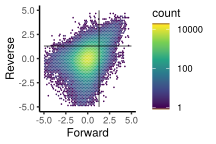

In [10]:
# assess orientation bias of all HiDRA fragments
options(repr.plot.width=3, repr.plot.height=2);
print(
    ggplot(data=as.data.frame(mcols(Fds)), aes(x=Fwd, y=Rev)) +
    geom_hex(bins=60) +
    geom_line( data=data.frame(), aes( x=1.3, y=-5:5 ), col="black", alpha=0.5) +
    geom_line( data=data.frame(), aes( x=-5:5, y=1.3 ), col="black", alpha=0.5) +
    scale_fill_viridis_c(trans="log10", limits=c(1, 10^4.2)) +
    xlim(-5, 5) + ylim(-5, 5) + xlab("Forward") + ylab("Reverse")
);
#ggsave("./out/HiDRA_FvRplot.pdf", width=3, height=2);
summary(factor(Fds$ecall));
print( round( cor.test(Fds$Fwd, Fds$Rev)$estimate^2, 3 ) );

Inactive     Bias Enhancer 
    1084      210       71

  cor 
0.163 


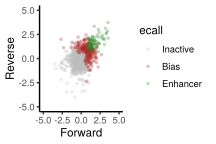

In [11]:
# subset on fragments derived from DHS (transcribed or untranscribed)
hits = findOverlaps( ActPk, Fds, type='within', minoverlap=150 );
hits = hits[!duplicated(hits@from)];
hpk = ActPk[hits@from];
hpk$Fwd = Fds$Fwd[hits@to];
hpk$Rev = Fds$Rev[hits@to];
hpk$pfwd = Fds$pfwd[hits@to];
hpk$prev = Fds$prev[hits@to];
hpk$ecall = Fds$ecall[hits@to];

print(
    ggplot(data=as.data.frame(mcols(hpk[order(hpk$ecall)])), aes(x=Fwd, y=Rev, col = ecall)) +
    geom_point(size=0.8, shape=16, alpha=0.3) +
    scale_color_manual(values=mycols) +
    xlim(-5, 5) + ylim(-5, 5) + xlab("Forward") + ylab("Reverse")
);
#ggsave("./out/HiDRA_DHS_FvR.pdf", width=3, height=2);

summary(factor(hpk$ecall));
print( round( cor.test(hpk$Fwd, hpk$Rev)$estimate^2, 3 ) );

In [12]:
# Now classify according to ChromHMM
hits = findOverlaps( ActPk, Fds );
hits = hits[!duplicated(hits@from)];
ActF = Fds[unique(hits@to)];
length(ActF)
# use chromHMM class with largest overlap on element
hits = getLargestOverlap(ActF, chromHMM);
ActF$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = ActF$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
ActF$cHMM = phmm;

[1] 29703

In [13]:
hits = getLargestOverlap(hpk, chromHMM);
hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
hpk$cHMM = phmm;

In [14]:
hpk$etype = factor( ifelse( hpk$ecall == "Enhancer", "Enhancer", "Inactive" ) );
hpk$class = factor( hpk$class );
levels(hpk$class) = c("Untranscibed", "Transcribed");

out = as.data.frame( mcols(hpk) ) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,42,42,100.0,100.0,100.0
TSS,Transcribed,Inactive,279,291,95.9,94.7,97.0
UpTSS,Untranscibed,Inactive,64,66,97.0,94.9,99.1
UpTSS,Transcribed,Inactive,374,392,95.4,94.4,96.5
Enh,Untranscibed,Inactive,27,28,96.4,92.9,99.9
Enh,Transcribed,Inactive,92,110,83.6,80.1,87.2
Other,Untranscibed,Inactive,196,199,98.5,97.6,99.4
Other,Transcribed,Inactive,220,237,92.8,91.2,94.5


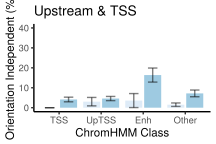

In [15]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") +
    ggtitle("Upstream & TSS");
#ggsave("./out/HiDRA_Full_ChromHMM.pdf", width=3, height=2);

In [16]:
# focus on sequences flanking DHS
fdhs = dhspk;
start(fdhs) = end(fdhs) - 70;
end(fdhs) = end(fdhs) + 180;
fdhs = append( fdhs, promoters(dhspk, upstream=180, downstream=70) );

# swap strands so start = end, allowing use of 'promoter' function
inTSS = TSS;
strand(inTSS) = ifelse(strand(inTSS) == "+", "-", "+");
inTSS = promoters(inTSS, upstream=70, downstream=180);

mcols(inTSS) = NULL;
fdhs$class = 0;
inTSS$class = 1;

In [17]:
flank_hpk = c( fdhs, inTSS ); # , indTSS );
hits = findOverlaps( flank_hpk, Fds, type='within' );
hits = hits[!duplicated(hits@from)];
flank_hpk = flank_hpk[hits@from];
flank_hpk$Fwd = Fds$Fwd[hits@to];
flank_hpk$Rev = Fds$Rev[hits@to];
flank_hpk$pfwd = Fds$pfwd[hits@to];
flank_hpk$prev = Fds$prev[hits@to];
flank_hpk$ecall = Fds$ecall[hits@to];

hits = getLargestOverlap(flank_hpk, chromHMM);
flank_hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = flank_hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
flank_hpk$cHMM = phmm;

flank_hpk$etype = factor(ifelse(flank_hpk$ecall == "Enhancer", "Enhancer", "Inactive"));
flank_hpk$class = factor( flank_hpk$class );
levels(flank_hpk$class) = c("Untranscibed", "Transcribed");

In [18]:
out = as.data.frame(mcols(flank_hpk)) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,1013,1015,99.8,99.7,99.9
TSS,Transcribed,Inactive,221,227,97.4,96.3,98.4
UpTSS,Untranscibed,Inactive,2372,2385,99.5,99.3,99.6
UpTSS,Transcribed,Inactive,375,391,95.9,94.9,96.9
Enh,Untranscibed,Inactive,1131,1133,99.8,99.7,99.9
Enh,Transcribed,Inactive,68,74,91.9,88.7,95.1
Other,Untranscibed,Inactive,9929,9972,99.6,99.5,99.6
Other,Transcribed,Inactive,141,148,95.3,93.5,97.0


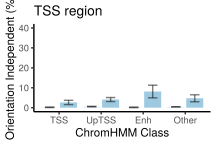

In [19]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("TSS region");
#ggsave("./out/HiDRA_Flank_ChromHMM.pdf", width=3, height=2);

In [20]:
# "central" sequences not defined from untranscribed DHS
indhs = dhspk;
inTSS = promoters(TSS, upstream=300, downstream=width(TSS)[1]-65);

mcols(inTSS) = NULL;
indhs$class = 0;
inTSS$class = 1;

In [21]:
central_hpk = c( indhs, inTSS ); #, indTSS );

hits = findOverlaps( Fds, central_hpk, type='within' );#, type='end', maxgap=10 );
hits = hits[!duplicated(hits@to)];
central_hpk = central_hpk[hits@to];
central_hpk$Fwd = Fds$Fwd[hits@from];
central_hpk$Rev = Fds$Rev[hits@from];
central_hpk$pfwd = Fds$pfwd[hits@from];
central_hpk$prev = Fds$prev[hits@from];
central_hpk$ecall = Fds$ecall[hits@from];

hits = getLargestOverlap(central_hpk, chromHMM);
central_hpk$cHMM[hits[,1]] = chromHMM$name[ hits[,2] ];
phmm = central_hpk$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");
central_hpk$cHMM = phmm;

central_hpk$etype = factor(ifelse(central_hpk$ecall == "Enhancer", "Enhancer", "Inactive"));
central_hpk$class = factor( central_hpk$class );
levels(central_hpk$class) = c("Untranscibed", "Transcribed");

In [22]:
out = as.data.frame( mcols(central_hpk) ) %>%
    group_by(cHMM, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

cHMM,class,etype,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Inactive,1037,1055,98.3,97.9,98.7
TSS,Transcribed,Inactive,413,418,98.8,98.3,99.3
UpTSS,Untranscibed,Inactive,2830,2908,97.3,97.0,97.6
UpTSS,Transcribed,Inactive,789,817,96.6,95.9,97.2
Enh,Untranscibed,Inactive,1010,1080,93.5,92.8,94.3
Enh,Transcribed,Inactive,224,231,97.0,95.8,98.1
Other,Untranscibed,Inactive,5299,5404,98.1,97.9,98.2
Other,Transcribed,Inactive,625,639,97.8,97.2,98.4


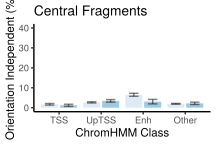

In [23]:
ggplot(out, aes(x=cHMM, y=100-pct, ymin=100-lower, ymax=100-upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Independent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Central Fragments");
#ggsave("./out/HiDRA_Central_ChromHMM.pdf", width=3, height=2);

In [25]:
lm_eqn = function(form, df) {
    m = lm(form, df);
    eq = substitute(italic(r)~"="~r2~"  "~italic(p) == pv,
        list(pv = format(anova(m)[1,5], digits = 2),
             r2 = format(sqrt(summary(m)$r.squared), digits = 2)))
    as.character(as.expression(eq));                 
}

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,4,42,9.52,4.99,14.1
TSS,Transcribed,Bias,59,291,20.27,17.92,22.6
UpTSS,Untranscibed,Bias,5,66,7.58,4.32,10.8
UpTSS,Transcribed,Bias,67,392,17.09,15.19,19.0
Enh,Untranscibed,Bias,4,28,14.29,7.67,20.9
Enh,Transcribed,Bias,17,110,15.45,12.01,18.9
Other,Untranscibed,Bias,18,199,9.05,7.01,11.1
Other,Transcribed,Bias,36,237,15.19,12.86,17.5


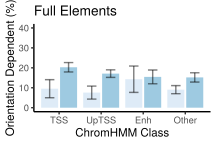

In [26]:
out = as.data.frame( mcols(hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out
options(repr.plot.width=3, repr.plot.height=2);
ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Upstream & TSS");
#ggsave("./out/HiDRA_OriBias_Full.pdf", width=3, height=2);

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,160,1055,15.17,14.06,16.27
TSS,Transcribed,Bias,52,418,12.44,10.83,14.05
UpTSS,Untranscibed,Bias,404,2908,13.89,13.25,14.53
UpTSS,Transcribed,Bias,99,817,12.12,10.98,13.26
Enh,Untranscibed,Bias,185,1080,17.13,15.98,18.28
Enh,Transcribed,Bias,37,231,16.02,13.60,18.43
Other,Untranscibed,Bias,615,5404,11.38,10.95,11.81
Other,Transcribed,Bias,56,639,8.76,7.65,9.88


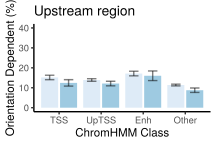

In [27]:
out = as.data.frame( mcols(central_hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out
ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("Upstream region");
#ggsave("./out/HiDRA_OriBias_Central.pdf", width=3, height=2);

cHMM,class,ecall,n,tot,pct,lower,upper
<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
TSS,Untranscibed,Bias,79,1015,7.78,6.94,8.62
TSS,Transcribed,Bias,36,227,15.86,13.43,18.28
UpTSS,Untranscibed,Bias,167,2385,7.00,6.48,7.52
UpTSS,Transcribed,Bias,67,391,17.14,15.23,19.04
Enh,Untranscibed,Bias,108,1133,9.53,8.66,10.40
Enh,Transcribed,Bias,11,74,14.86,10.73,19.00
Other,Untranscibed,Bias,672,9972,6.74,6.49,6.99
Other,Transcribed,Bias,15,148,10.14,7.65,12.62


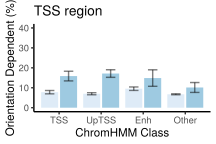

In [28]:
out = as.data.frame( mcols(flank_hpk) ) %>%
    group_by(cHMM, class, ecall) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) ) %>%
    filter( ecall == "Bias" );
out

ggplot(out, aes(x=cHMM, y=pct, ymin=lower, ymax=upper, fill=class, label=tot-n)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("Type") +
    ylab("Orientation Dependent (%)") +
    xlab("ChromHMM Class") + 
    ggtitle("TSS region");
#ggsave("./out/HiDRA_OriBias_Flanking.pdf", width=3, height=2);